# Final sizes
Checking whether the final sizes of commuters vs noncommuters deviates from what we'd expect in one way models

In [5]:
%load_ext autoreload
%autoreload 2
from basic_epidemic import fit_model, visualise_fits, calculate_r0
from itertools import product
import numpy as np
from analysis import filter_population
import matplotlib.pyplot as plt
from grab_data import get_matrix, get_population_sizes
from base_model import simulate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
flow_matrix = get_matrix(full=True)
pop_sizes = get_population_sizes()
home_sizes = flow_matrix.diagonal()
commuter_sizes = flow_matrix.sum(axis=1) - home_sizes
total_pop = pop_sizes.sum()

In [7]:
n_samples = 150
base_params = dict(beta=1.5, psi=0.8, gamma=0.8, population_sizes=pop_sizes, flow_matrix=flow_matrix, t_max=250,
                   t_delta=1, seed=0, seed_amount=1)
storage_shape = (n_samples, np.ceil((base_params['t_max'] / base_params['t_delta'])).astype(int), flow_matrix.shape[0],
                 flow_matrix.shape[0])
r_s, r_i, p_s, p_i = np.zeros(storage_shape), np.zeros(storage_shape), np.zeros(storage_shape), np.zeros(storage_shape)

In [4]:
for j in range(n_samples):
    r_sim = simulate(**base_params, model='random')
    p_sim = simulate(**base_params, model='perfect')
    while r_sim[1].sum(axis=(0, 1, 2)) / total_pop < 0.1:
        r_sim = simulate(**base_params, model='random')
    r_s[j, :], r_i[j, :], _ = r_sim
    while p_sim[1].sum(axis=(0, 1, 2)) / total_pop < 0.01:
        p_sim = simulate(**base_params, model='perfect')
    p_s[j, :], p_i[j, :], _ = p_sim

KeyboardInterrupt: 

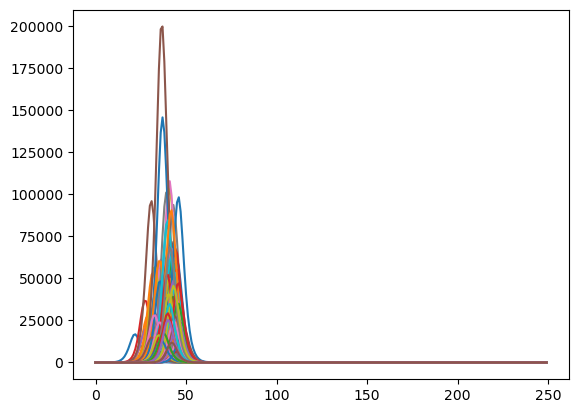

In [36]:
plt.plot(r_i[0, ...].sum(axis=2))
plt.show()

In [37]:
r_overall_final_sizes = 1 - r_s[:, -1, ...].sum(axis=(1, 2)) / pop_sizes.sum()
p_overall_final_sizes = 1 - p_s[:, -1, ...].sum(axis=(1, 2)) / pop_sizes.sum()

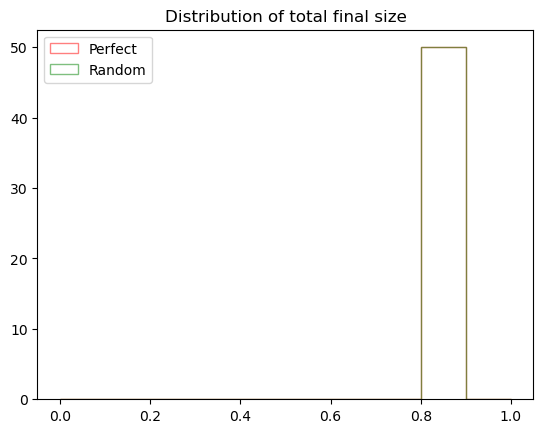

In [38]:
plt.hist(p_overall_final_sizes, range=(0, 1), bins=10, color='r', label='Perfect', alpha=0.5, histtype='step')
plt.hist(r_overall_final_sizes, range=(0, 1), bins=10, color='g', label='Random', alpha=0.5, histtype='step')
plt.legend()
plt.title('Distribution of total final size')
plt.show()

In [30]:
def simulate_and_fit(flow_matrix, population_sizes, t_max=200, t_delta=1, model='perfect'):
    true_params = list(product(np.linspace(1, 4, 5), np.linspace(0.2, 0.8, 2), np.array([0.8])))
    results = [[], [], []]
    true_r0, estimated_r0 = [], []
    for b, g, p in true_params:
        r0 = calculate_r0(beta=b, gamma=g, psi=p, flow_matrix=flow_matrix, population_sizes=population_sizes)
        print(b, g, p, r0)
        if r0 <= 1:
            continue
        params = dict(beta=b, gamma=g,
                      psi=p, flow_matrix=flow_matrix,
                      population_sizes=population_sizes,
                      seed=0, seed_amount=1, t_max=t_max, t_delta=t_delta, model=model)
        sim_data = simulate(**params)
        # not interested in extinctions
        while sim_data[1].sum(axis=(0, 1, 2)) / population_sizes.sum() <= 0.05:
            sim_data = simulate(**params)
        # reduce to flattened SIR
        s, i, r = sim_data[0].sum(axis=2), sim_data[1].sum(axis=2), sim_data[2].sum(axis=2)
        b_hat, g_hat, psi_hat = fit_model((s, i, r), flow_matrix, population_sizes, t_delta=t_delta)
        true_r0.append(r0)
        estimated_r0.append(calculate_r0(b_hat, g_hat, psi_hat, flow_matrix, population_sizes))
        results[0].append(b_hat)
        results[1].append(g_hat)
        results[2].append(psi_hat)

    return np.array(true_params), np.array(results).T, np.array(true_r0), np.array(estimated_r0)


res = simulate_and_fit(flow_matrix=flow_matrix, population_sizes=pop_sizes)

1.0 0.2 0.8 4.646338531288436
1.0 0.8 0.8 1.161584632822109


KeyboardInterrupt: 

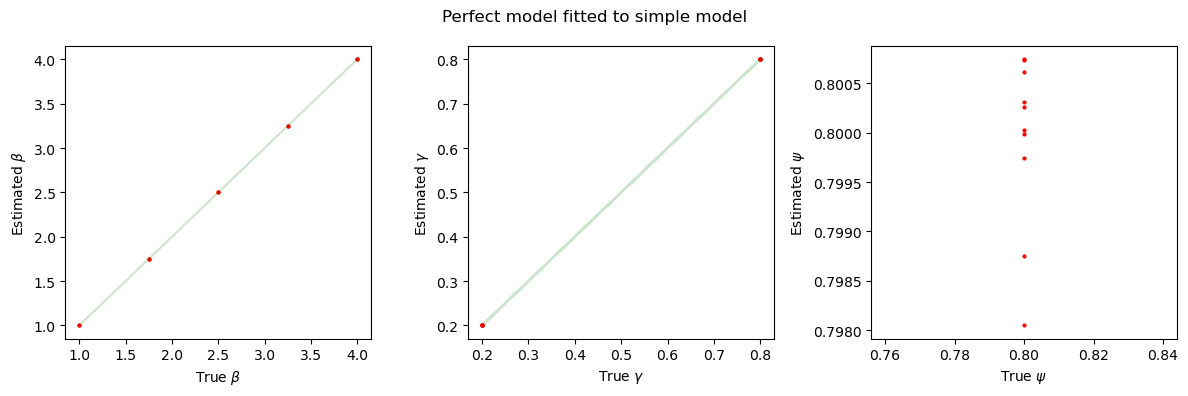

In [11]:
true_params, est_params, true_r0, est_r0 = res
visualise_fits(true_params, est_params, title='Perfect model fitted to simple model')

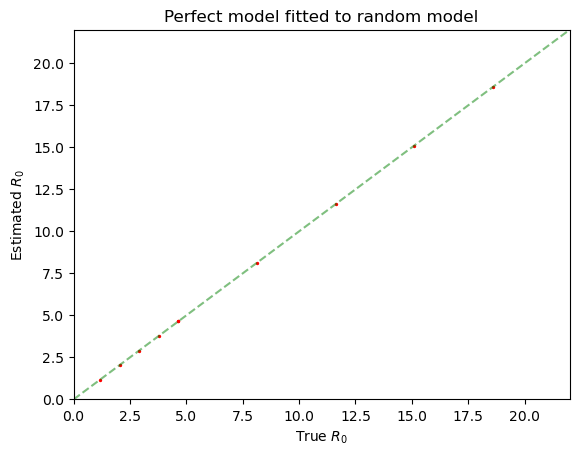

In [12]:
plt.scatter(true_r0, est_r0, s=2, c='r')
plt.plot(np.linspace(0,22,100), np.linspace(0,22,100), c='g', linestyle='--', alpha=0.5)
plt.xlabel('True $R_0$')
plt.xlim(0,22)
plt.ylim(0,22)
plt.ylabel('Estimated $R_0$')
plt.title('Perfect model fitted to random model')
plt.show()

In [ ]:
commuters_r_s, commuters_r_i, home_r_s, home_r_i = filter_population(r_s, r_i)
commuters_p_s, commuters_p_i, home_p_s, home_p_i = filter_population(p_s, p_i)

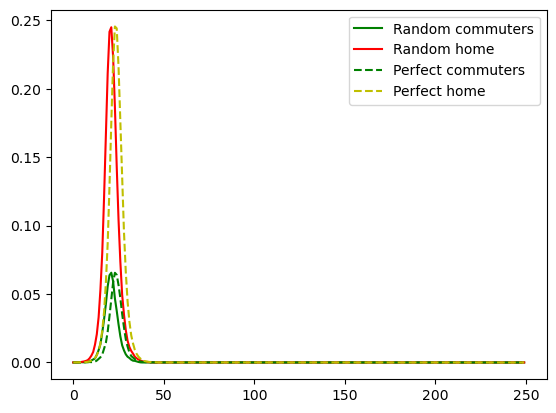

In [32]:
patches = [0]
sample = 0
for patch in patches:
    commuter_infections = commuter_sizes[patch] / pop_sizes[patch] * r_i[sample, :, patch, :].sum(axis=1)
    home_infections = home_size[patch] / pop_sizes[patch] * r_i[sample, :, patch, :].sum(axis=1)
    plt.plot(commuters_r_i[sample, :, patch]/commuter_sizes[patch], label='Random commuters', c='g')
    plt.plot(home_r_i[sample, :, patch]/home_size[patch], label='Random home', c='r')
    plt.plot(commuters_p_i[sample, :, patch]/commuter_sizes[patch], label='Perfect commuters', c='g', linestyle='--')
    plt.plot(home_p_i[sample, :, patch]/home_size[patch], label='Perfect home', c='y', linestyle='--')
plt.legend()
plt.show()

In [27]:
commuters_r_final_sizes = 1 - commuters_r_s[:, -1, :]/commuter_sizes
home_r_final_sizes = 1 - home_r_s[:, -1, :]/home_size

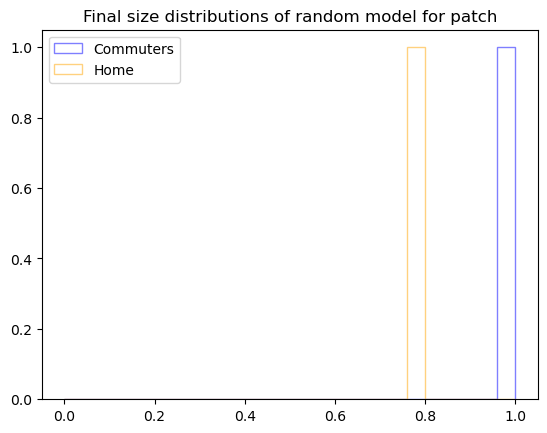

In [28]:
patch = 300
common_params = dict(range=(0, 1), bins=25, histtype='step', alpha=0.5)
plt.hist(commuters_r_final_sizes[:, patch], label='Commuters', color='blue', **common_params)
plt.hist(home_r_final_sizes[:, patch], label='Home', color='orange', **common_params)
#plt.axvline(a, color='green', linestyle='dashed', linewidth=1)
plt.title('Final size distributions of random model for patch')
plt.legend()
plt.show()

In [187]:
commuters_r_final_sizes[:, patch]

array([0.99998302, 0.99998302, 0.99999151, 0.99995755, 0.99996604])

In [188]:
home_r_final_sizes[:, patch]

array([0.99966885, 0.99969433, 0.99959244, 0.99961791, 0.99967735])